In [1]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source

import matplotlib
import numpy as np

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf (+ faster)
# %matplotlib widget

In [3]:
exec(open('../TEST_DATA_PATH.py').read())

### Load raw data

In [4]:
options_dict = {
    "base_dir": TEST_DATA_PATH, # var is read from TEST_DATA_PATH.py
    "filepath": "pycontrol_test/003_esr",
    "custom_output_dir_suffix": "_{ROI}_bin_{total_bin}",

    "smoothing_sigma_px": 4,
    "additional_bins": 4,

    "system_name": "Py_Cryo_Widefield",

    "ROI": "Full", 
    
    "AOI_1_start": [30, 40],
    "AOI_1_end": [40, 45], 
    "single_pixel_check": [90, 150],
    
    "fit_backend": "cpufit",
    "fit_backend_comparison": ["cpufit", "scipyfit"],
    "fit_pl_pixels": True, 
    "force_fit": True, 

    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 0],
    "diamond_ori": "<100>_<110>",
        
    "scipyfit_sub_threads": 2, 
    "remove_start_sweep": 1,

    "fit_functions":  {"linear": 1, "lorentzian": 1},

    "pos_guess": [2465, 0],
    "pos_range": 25,

    "amp_guess": -0.015,
    "amp_bounds": [-0.0300, -0.0003],
    
    "save_fig_type": "pdf",
    "field_method": "auto_dc",

    "bnv_bground_method": "poly",
    "bnv_bground_params": {
        "order": 1,
    }
}
# if you want to use a reference experiment {ensure you run this even if 'None' as it sets up output dirs etc.}
ref_options_dir = None

In [5]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=ref_options_dir,
    set_mpl_rcparams=True
)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(msg, QDMPYWarning)


### Load data

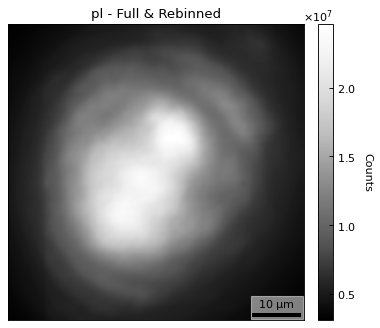

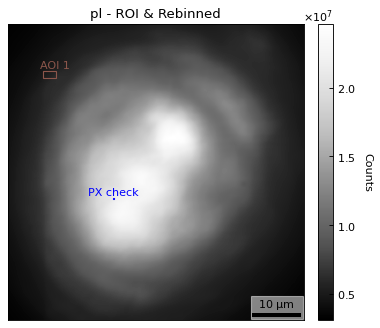

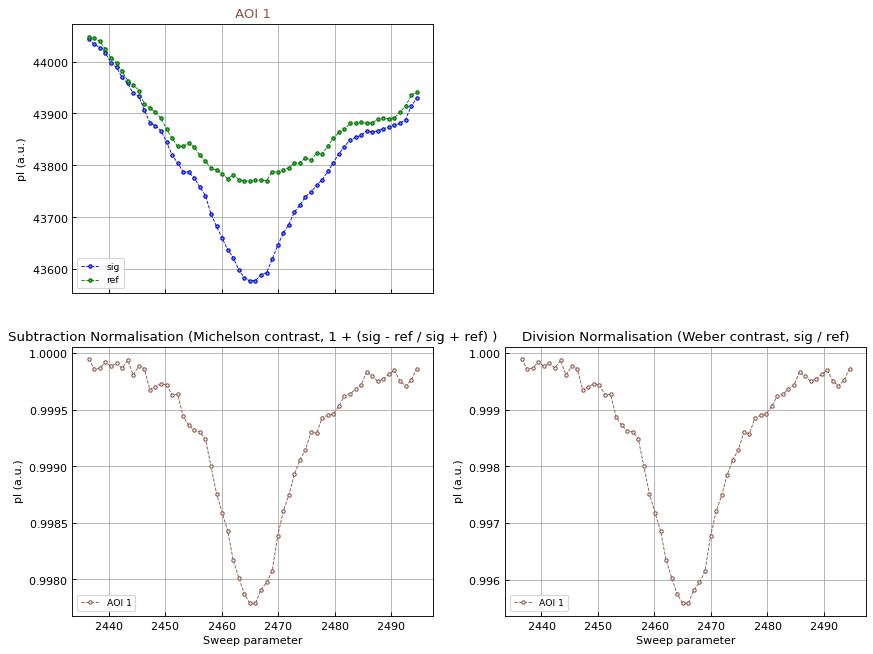

In [6]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )
ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)

AOI_PL_fig = qdmpy.plot.aoi_pl_image(options, PL_image_ROI)

AOI_spectra_fig = qdmpy.plot.aoi_spectra(options, sig, ref, sweep_list)

qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

In [7]:
image.dtype

dtype('uint64')

### Load reference experiment - note, you can fit in this same notebook!

In [8]:
ref_fit_params, ref_sigmas = qdmpy.pl.load_ref_exp_pl_fit_results(ref_options)

### Fit AOI, ROI averages, single pixel

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/pl/scipyfit.py:35: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # auto detects jupyter


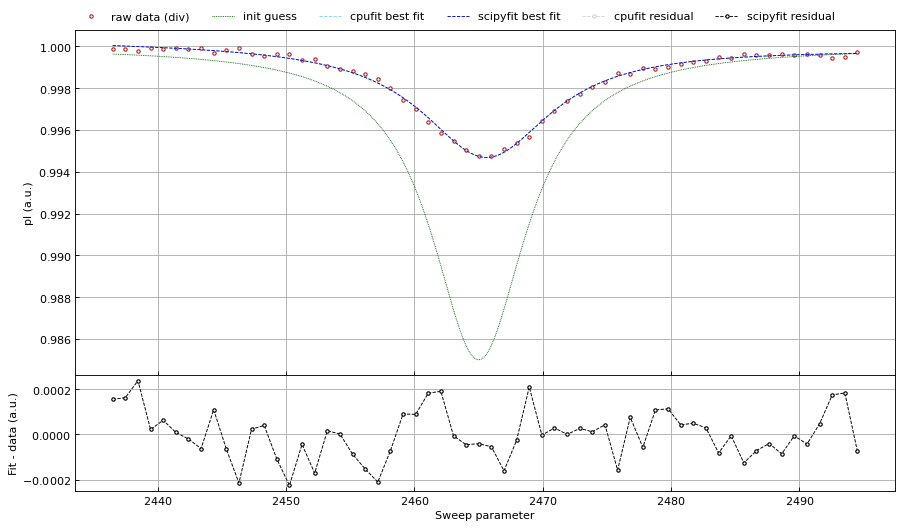

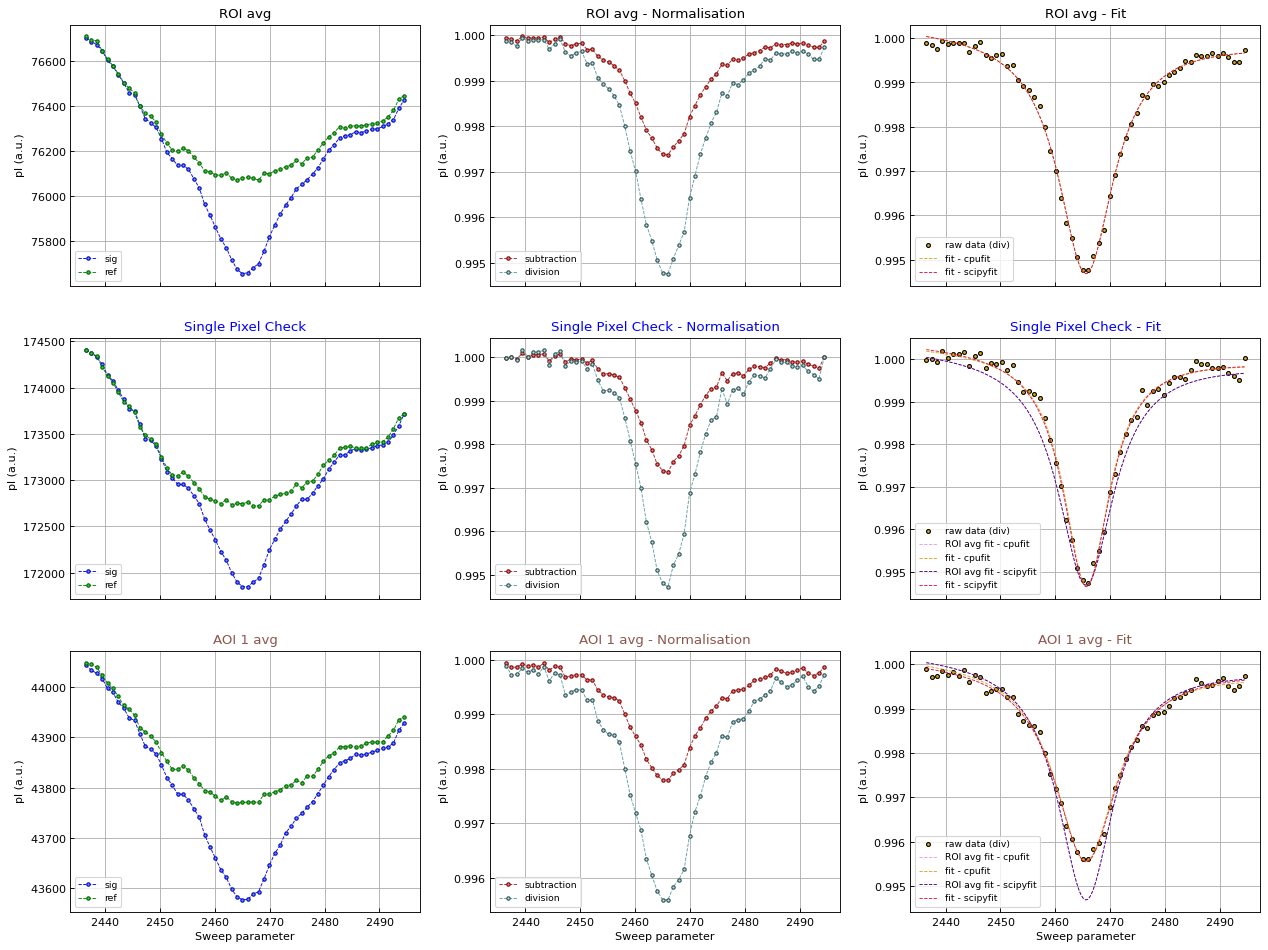

In [9]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, sig, ref, sweep_list, fit_model)
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)

fit_result_collection_lst = qdmpy.pl.fit_aois_pl(options, sig, ref, single_pixel_pl, sweep_list, fit_model, backend_ROI_results_lst)
AOI_fit_fig = qdmpy.plot.aoi_spectra_fit(options, sig, ref, sweep_list, fit_result_collection_lst, fit_model)

### Fit pixels

In [10]:
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)

qdmpy.pl.save_pl_fit_results(options, pixel_fit_params)
qdmpy.pl.save_pl_fit_sigmas(options, sigmas)

### Plot (fit) parameters

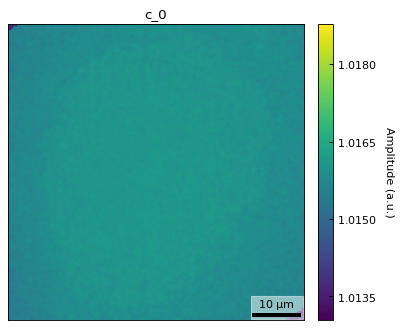

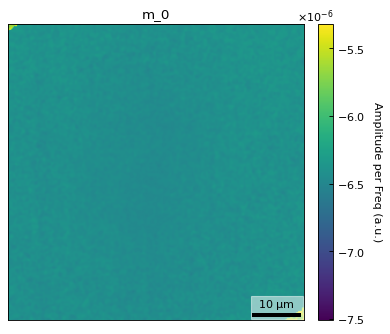

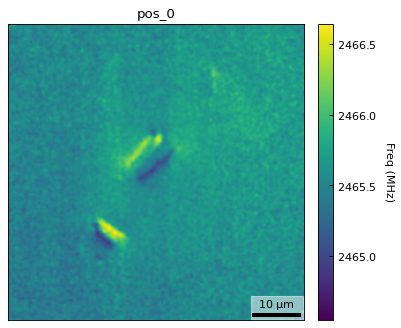

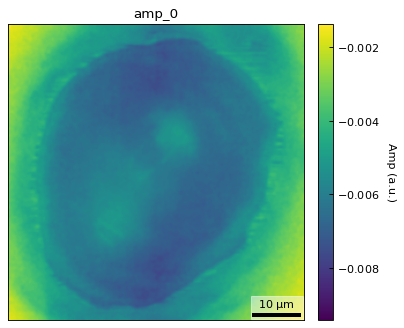

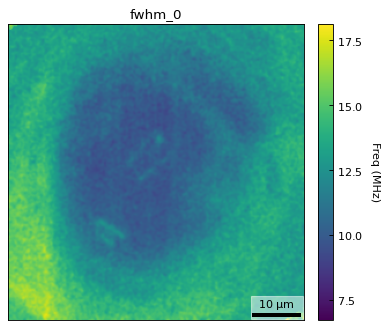

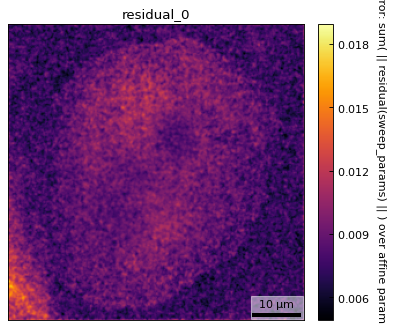

In [11]:
c_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "c")
m_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "m")
pos_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "pos")
amp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "amp")
fwhm_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "fwhm")
residual_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "residual")

In [12]:
field_res = qdmpy.field.odmr_field_retrieval(options, pixel_fit_params, ref_fit_params)
(sig_bnvs, ref_bnvs, bnvs), (sig_dshifts, ref_dshifts), (sig_params, ref_params, field_params), (sig_field_sigmas, ref_field_sigmas, field_sigmas) = field_res
qdmpy.field.save_field_calcs(options, *field_res)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Using previous field calculation.
  warnings.warn(msg, QDMPYWarning)


/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/plot/common.py:360: RuntimeWarning: All-NaN slice encountered
  return [np.nanmin(image), np.nanmax(image)]


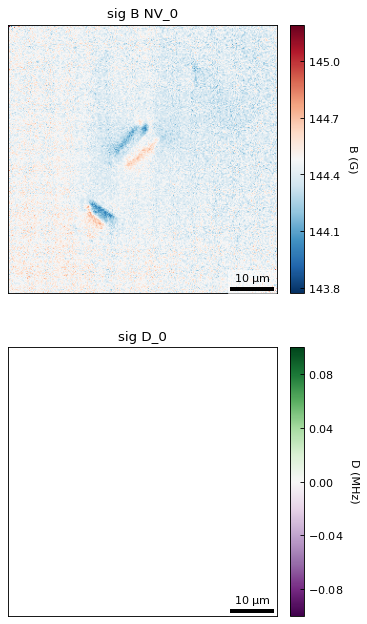

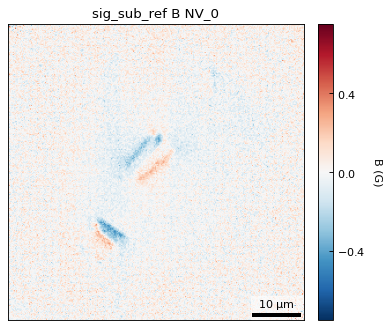

In [13]:
bnv_sig_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig", sig_bnvs, sig_dshifts)
bnv_ref_plot = qdmpy.plot.bnvs_and_dshifts(options, "ref", ref_bnvs, ref_dshifts)
bnvs_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig_sub_ref", bnvs, [])

In [14]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))